In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns

In [3]:
def remove_some_border(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

def gtex_scatter_with_densities(x, y, output, xlab=None, ylab=None, ylim=None, title=None):
    fig, axes = plt.subplots(2,2, gridspec_kw={'height_ratios': [1, 3],'width_ratios': [3, 1]})
    fig.set_size_inches(10, 10)
    axes[1,0].scatter(x, y,s=4)
    axes[1,0].set_xlabel('Number of tissues the gene is sex-based differentially expressed in')
    axes[1,0].set_ylabel(ylab)
    axes[0,0].set_title(title)
    axes[1,0].set_ylim(0,800)
    axes[0,0].hist(x,bins=44)
    axes[1,1].hist(y,orientation='horizontal',bins=44)
    if ylim is not None:
        axes[1,1].set_ylim(ylim[0],ylim[1])
    axes[0,0].set_xlim(0,44)
    axes[0,1].set_visible(False)
    remove_some_border(axes[0,0])
    remove_some_border(axes[1,0])
    remove_some_border(axes[1,1])
    plt.savefig(output,dpi=300)
    plt.show()

def compare_annotations_by_sex(female_x,male_x,title,output,xlabel):
    y1, binEdges1, z1= plt.hist(male_x,bins=100,color='blue')
    y2, binEdges2, z2 = plt.hist(female_x,bins=100,color='red')
    plt.clf()

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)

    bincenters1 = 0.5 * (binEdges1[1:] + binEdges1[:-1])
    bincenters2 = 0.5 * (binEdges2[1:] + binEdges2[:-1])
    plt.plot(bincenters1, y1, '-', c='blue',label='Male')
    plt.plot(bincenters2, y2, '-', c='red',label='Female')
    plt.legend()
    plt.ylabel('Number of genes')
    plt.xlabel(xlabel)
    plt.title(title)
    plt.savefig(output,dpi=300)
    plt.show()

## Load sex specific gene information

In [4]:

xls = pd.ExcelFile('../Resources/aba3066-table-s2.xlsx')

gene_tissue_counts_female = {}
gene_tissue_counts_male = {}
t2g2s = {'tissue':[],'gene':[],'sex':[]}
tissue_2_gene_by_sex = {}
for sheet_name in xls.sheet_names[2:]:
    xdf = xls.parse(sheet_name)
    for i,row in xdf.iterrows():
        g = row['HUGO_gene_id']
        is_female = row['MASH beta'] > 0
        if is_female:
            if g not in gene_tissue_counts_female:
                gene_tissue_counts_female[g] = 0
            gene_tissue_counts_female[g] += 1
            t2g2s['tissue'].append(sheet_name)
            t2g2s['gene'].append(g)
            t2g2s['sex'].append('female')
        else:
            if g not in gene_tissue_counts_male:
                gene_tissue_counts_male[g] = 0
            gene_tissue_counts_male[g] += 1
            t2g2s['tissue'].append(sheet_name)
            t2g2s['gene'].append(g)
            t2g2s['sex'].append('male')

# build a DF for these that are differentially expressed and with greater expression in females
genes_female = gene_tissue_counts_female.keys()
data_female = {'gene':genes_female,'tissue_count':[gene_tissue_counts_female[g] for g in genes_female]}
df_female = pd.DataFrame(data_female)
df_female['tissue_count'].max()
print('females',df_female[df_female['tissue_count'] == df_female['tissue_count'].max()])
df_female = df_female[df_female['tissue_count'] < 45]
print('females',df_female.shape)

# build a DF for these that are differentially expressed and with greater expression in males
genes_male = gene_tissue_counts_male.keys()
data_male = {'gene':genes_male,'tissue_count':[gene_tissue_counts_male[g] for g in genes_male]}
df_male = pd.DataFrame(data_male)
df_male['tissue_count'].max()
print('males',df_male[df_male['tissue_count'] == df_male['tissue_count'].max()])
df_male = df_male[df_male['tissue_count'] < 45]
print('males',df_male.shape)

females    gene  tissue_count
27  NaN           739
females (2433, 2)
males   gene  tissue_count
3  NaN          1090
males (2364, 2)


## Gene Ontology

In [5]:
# add the number of GO annotations for each gene
go_annotations = {}
for line in open('../Resources/goa_human.jan_16_2023.gaf','r'):
    if line[0] == '!':
        continue
    gene = line.split('\t')[2]
    if gene not in go_annotations:
        go_annotations[gene] = 0
    go_annotations[gene] += 1

# add this information to each of the DFs
df_female['GO_annotations'] = [go_annotations[g] if g in go_annotations else 0 for g in df_female['gene']]
# same for df_males
df_male['GO_annotations'] = [go_annotations[g] if g in go_annotations else 0 for g in df_male['gene']]

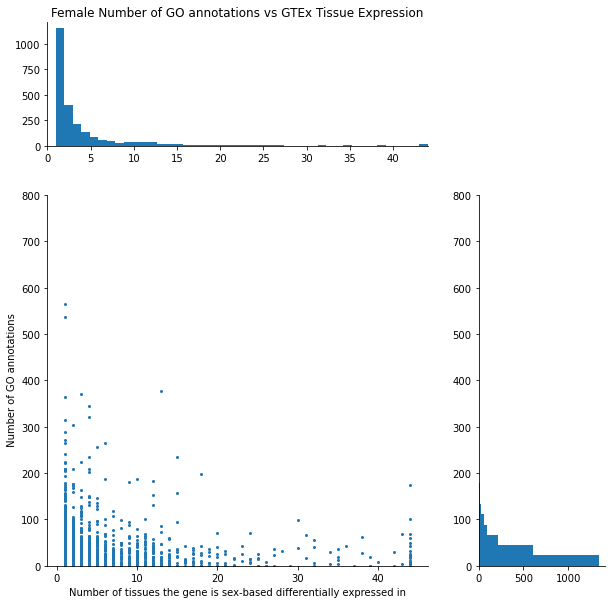

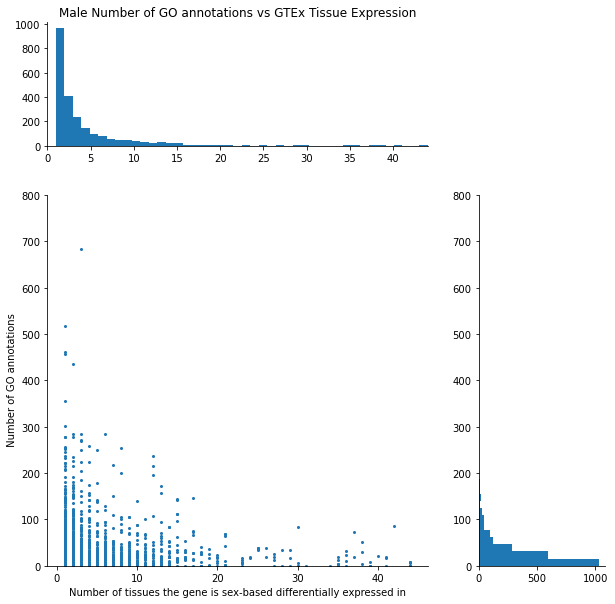

<Figure size 432x288 with 0 Axes>

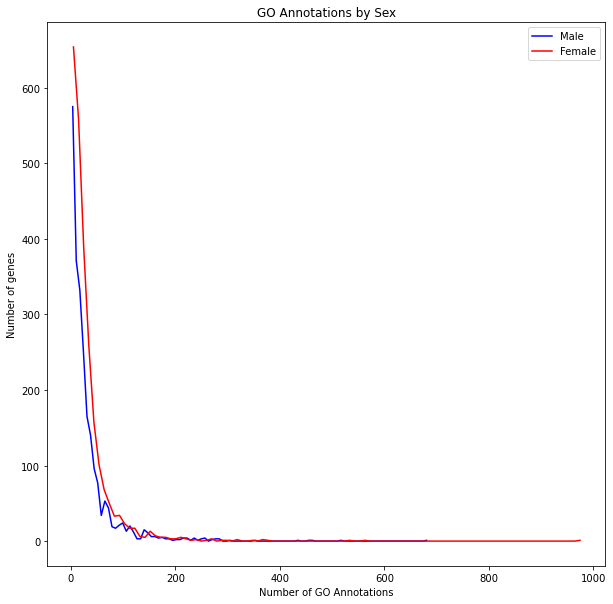

In [6]:
# Plot that shit!
# x, y, output, xlab=None, ylab=None, ylim=None, title=None
gtex_scatter_with_densities(x=df_female['tissue_count'],
                            y=df_female['GO_annotations'],
                            output='../Figures/female_go_v_gtex_scatter.png',
                            ylab=' Number of GO annotations',
                            ylim=(0,800),
                            title='Female Number of GO annotations vs GTEx Tissue Expression')

gtex_scatter_with_densities(x=df_male['tissue_count'],
                            y=df_male['GO_annotations'],
                            output='../Figures/Male_go_v_gtex_scatter.png',
                            ylab=' Number of GO annotations',
                            ylim=(0,800),
                            title='Male Number of GO annotations vs GTEx Tissue Expression')

compare_annotations_by_sex(df_female['GO_annotations'],
                            df_male['GO_annotations'],
                            title='GO Annotations by Sex',
                            output='../Figures/go_annotations_by_sex.png',
                            xlabel='Number of GO Annotations')

19563
['FEM1A', 'GRAPL', 'PALD1', 'NAA10', 'SMG6', 'HLTF', 'ZDHHC1', 'NCAPD3', 'DDX47', 'ENSG00000279374']


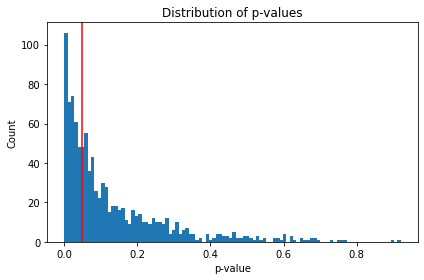

p < 0.05: 389
% p < 0.05: 0.389


0.389

In [19]:
# is the distribution of GO annotations in sex specific genes different than expected as random?
all_go_annotations_counts = list(df_male['GO_annotations']) + list(df_female['GO_annotations'])

# gene: count
go_annotations
# load a list of all genes
all_gene_symbols = list(set([ line.strip().split('\t')[1] for line in open('../Resources/9606.protein.info.v11.5.txt','r') if line[0] != '#']))
print(len(all_gene_symbols))
# print first 10 symbols
print(all_gene_symbols[:10])
all_gene_go_counts = [go_annotations[g] if g in go_annotations else 0 for g in all_gene_symbols]

# function for sample a distribitions of annotions x times and do a t-test between the given and generated distributions
def sample_and_ttest(actual_counts,all_gene_counts,iterations=1000,plt_prefix=None):
    # set seed for np.random
    np.random.seed(1)
    ps = []
    ts = []
    for i in range(iterations):
        # sample len(actual_counts) times from all_gene_counts
        sampled_counts = np.random.choice(all_gene_counts,size=len(actual_counts),replace=False)
        # do a t-test between the actual and sampled counts
        t,p = stats.ttest_ind(actual_counts,sampled_counts)
        # append the p and t values to the lists
        ps.append(p)
        ts.append(t)
        # print('t:',t,'p:',p)
        # plot the two distributions
        if iterations > 1 or plt_prefix is None:
            continue
        fig, ax = plt.subplots(2)
        # set fig size
        fig.set_size_inches(5,5)
        ax[0].hist(actual_counts)
        ax[1].hist(sampled_counts)
        # label x axes
        ax[0].set_xlabel('Number of GO annotations')
        ax[1].set_xlabel('Number of GO annotations')
        # label y
        ax[0].set_ylabel('Count')
        ax[1].set_ylabel('Count')
        # title each ax
        ax[0].set_title('Actual n={}'.format(len(actual_counts)))
        ax[1].set_title('Sampled n={} p={} t={}'.format(len(sampled_counts),round(p,4),round(t,4)))
        # save the figure
        plt.tight_layout()
        fig.savefig('{}actual_v_sampled_go_counts.png'.format(plt_prefix))
        plt.show()
    # plot the distribution of p-values
    if plt_prefix is not None:
        plt.hist(ps,bins=100)
        # red vertical line at 0.05
        plt.axvline(x=0.05,color='red')
        plt.xlabel('p-value')
        plt.ylabel('Count')
        plt.title('Distribution of p-values')
        plt.tight_layout()
        plt.savefig('{}p_value_distribution.png'.format(plt_prefix))
        plt.show()
    # print the number of p-values less than 0.05
    print('p < 0.05:',len([p for p in ps if p < 0.05]))
    # print the % of p-values less than 0.05
    print('% p < 0.05:',len([p for p in ps if p < 0.05])/len(ps))
    # return the % significant p-values
    return len([p for p in ps if p < 0.05])/len(ps)

sample_and_ttest(all_go_annotations_counts, all_gene_go_counts, iterations=1000, plt_prefix='../Figures/go_general_bias_')

for genes expressed in 1 specific tissues
p < 0.05: 346
% p < 0.05: 0.346
for genes expressed in 2 specific tissues
p < 0.05: 41
% p < 0.05: 0.041
for genes expressed in 3 specific tissues
p < 0.05: 150
% p < 0.05: 0.15
for genes expressed in 4 specific tissues
p < 0.05: 333
% p < 0.05: 0.333
for genes expressed in 5 specific tissues
p < 0.05: 11
% p < 0.05: 0.011
for genes expressed in 6 specific tissues
p < 0.05: 4
% p < 0.05: 0.004
for genes expressed in 7 specific tissues
p < 0.05: 17
% p < 0.05: 0.017
for genes expressed in 8 specific tissues
p < 0.05: 4
% p < 0.05: 0.004
for genes expressed in 9 specific tissues
p < 0.05: 10
% p < 0.05: 0.01
for genes expressed in 10 specific tissues
p < 0.05: 28
% p < 0.05: 0.028
for genes expressed in 11 specific tissues
p < 0.05: 28
% p < 0.05: 0.028
for genes expressed in 12 specific tissues
p < 0.05: 14
% p < 0.05: 0.014
for genes expressed in 13 specific tissues
p < 0.05: 2
% p < 0.05: 0.002
for genes expressed in 14 specific tissues
p < 0.

/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_67900/4158834216.py:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p = stats.ttest_ind(actual_counts,sampled_counts)


p < 0.05: 24
% p < 0.05: 0.024
for genes expressed in 41 specific tissues
p < 0.05: 26
% p < 0.05: 0.026
for genes expressed in 42 specific tissues
p < 0.05: 0
% p < 0.05: 0.0
for genes expressed in 43 specific tissues
p < 0.05: 1
% p < 0.05: 0.001
for genes expressed in 44 specific tissues
p < 0.05: 1
% p < 0.05: 0.001


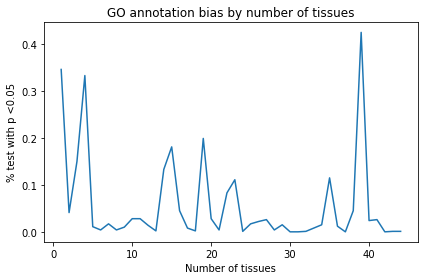

In [31]:
"""
for t in T, number of tissues a gene is sex-specifically expressed in (1-44)
is the number of GO annotations at t different than expected by chance?
"""
ps_at_t = []
ts = []
for t in range(1,max([max(df_male['tissue_count']), max(df_female['tissue_count']) ])+1):
    print('for genes expressed in {} specific tissues'.format(t))
    # get the genes expressed in t tissues
    sub_female = df_female[df_female['tissue_count'] == t]
    sub_male = df_male[df_male['tissue_count'] == t]
    all_go_annos_at_t = list(sub_male['GO_annotations']) + list(sub_female['GO_annotations'])
    if len(all_go_annos_at_t) == 0:
        print('no genes expressed in {} tissues'.format(t))
        continue

    p_at_t = sample_and_ttest(all_go_annos_at_t, all_gene_go_counts, iterations=1000)
    ps_at_t.append(p_at_t)
    ts.append(t)
# plot the p-values at each t
plt.plot(ts,ps_at_t)
plt.xlabel('Number of tissues')
plt.ylabel('% test with p <0.05')
plt.title('GO annotation bias by number of tissues')
plt.tight_layout()
plt.savefig('../Figures/go_annotation_bias_by_tissue.png')
plt.show()




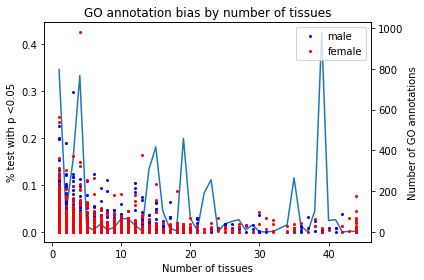

max p: 0.425 max t: 39
Female # genes at t=39, 3
Male # genes at t=39, 4
mean number of GO annotations at t=39: 4.0
median number of GO annotations at t=39: 0.0
std number of GO annotations at t=39: 7.091242083423347
mean number of GO annotations for all genes: 30.283494351582068
median number of GO annotations for all genes: 18.0
std number of GO annotations for all genes: 45.157286018045546


In [33]:
# make a plot with two y axis
# on the first plot ts vs ps_at_t
# on the second do a scatter plot of df_male['tissue_count'], df_male['GO_annotations']
ax1 = plt.subplot()
l1, = ax1.plot(ts,ps_at_t)
ax1.set_xlabel('Number of tissues')
ax1.set_ylabel('% test with p <0.05')
ax2 = ax1.twinx()
l2, = ax2.plot(df_male['tissue_count'], df_male['GO_annotations'], color='blue', marker='o', linestyle='None', markersize=2,label='male')
l2, = ax2.plot(df_female['tissue_count'], df_female['GO_annotations'], color='red', marker='o', linestyle='None', markersize=2,label='female')
ax2.set_ylabel('Number of GO annotations')
ax2.legend()
plt.title('GO annotation bias by number of tissues')
plt.tight_layout()
plt.savefig('../Figures/go_annotation_bias_by_tissue_with_scatter_and_percent_line.png')
plt.show()

# find the max ps_at_t and it's corresponding t
max_p = max(ps_at_t)
max_t = ts[ps_at_t.index(max_p)]
print('max p:',max_p,'max t:',max_t)

# print the number of genes expressed in max_t tissues
df_male_max_t = df_male[df_male['tissue_count'] == max_t]
df_female_max_t = df_female[df_female['tissue_count'] == max_t]
print('Female # genes at t={}, {}'.format(max_t, df_female_max_t.shape[0]))
print('Male # genes at t={}, {}'.format(max_t, df_male_max_t.shape[0]))
# mean number of GO annotations at t
num_annotations_at_max_t = list(df_female_max_t['GO_annotations']) + list(df_male_max_t['GO_annotations'])
# mean of num_annotations_at_max_t
print('mean number of GO annotations at t={}: {}'.format(max_t, np.mean(num_annotations_at_max_t)))
# median of num_annotations_at_max_t
print('median number of GO annotations at t={}: {}'.format(max_t, np.median(num_annotations_at_max_t)))
# std of num_annotations_at_max_t
print('std number of GO annotations at t={}: {}'.format(max_t, np.std(num_annotations_at_max_t)))
# what is the mean median and std of all_gene_go_counts?
print('mean number of GO annotations for all genes: {}'.format(np.mean(all_gene_go_counts)))
print('median number of GO annotations for all genes: {}'.format(np.median(all_gene_go_counts)))
print('std number of GO annotations for all genes: {}'.format(np.std(all_gene_go_counts)))



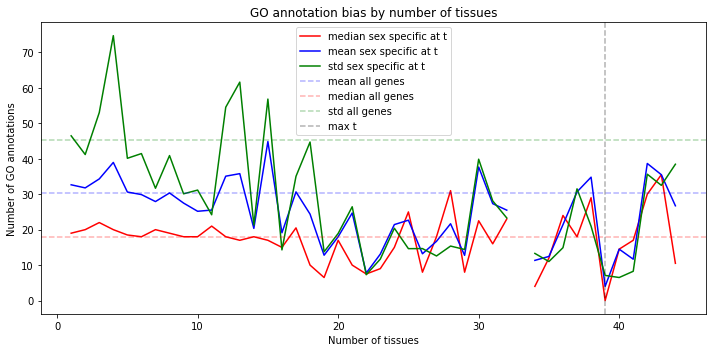

In [40]:
# plot the median and mean number of annotations at each t
# get the median and mean number of annotations at each t
medians_at_t = []
means_at_t = []
stds_at_t = []
for t in range(1,45):
    df_male_t = df_male[df_male['tissue_count'] == t]
    df_female_t = df_female[df_female['tissue_count'] == t]
    # get the median and mean number of annotations at t
    num_annotations_at_max_t = list(df_male_t['GO_annotations']) + list(df_female_t['GO_annotations'])
    medians_at_t.append(np.median(num_annotations_at_max_t))
    means_at_t.append(np.mean(num_annotations_at_max_t))
    stds_at_t.append(np.std(num_annotations_at_max_t))

# plot the median and mean number of annotations at each t
fig, ax = plt.subplots()
# chagne fig size
fig.set_size_inches(10, 5)
plt.plot(range(1,45),medians_at_t, label='median sex specific at t',color='red')
plt.plot(range(1,45),means_at_t, label='mean sex specific at t',color='blue')
plt.plot(range(1,45),stds_at_t, label='std sex specific at t',color='green')

# plot the mean, median and std of all_gene_go_counts as horizontal lines
plt.axhline(y=np.mean(all_gene_go_counts), color='blue', linestyle='--', label='mean all genes',alpha=.3)
plt.axhline(y=np.median(all_gene_go_counts), color='red', linestyle='--', label='median all genes',alpha=.3)
plt.axhline(y=np.std(all_gene_go_counts), color='green', linestyle='--', label='std all genes',alpha=.3)

# mark the max t with a verticle line that is alpha = .3
plt.axvline(x=max_t, color='black', linestyle='--', alpha=.3, label='max t')

plt.xlabel('Number of tissues')
plt.ylabel('Number of GO annotations')
plt.title('GO annotation bias by number of tissues')
plt.legend()
plt.tight_layout()
plt.savefig('../Figures/go_annotation_bias_by_tissue_median_mean_std.png')

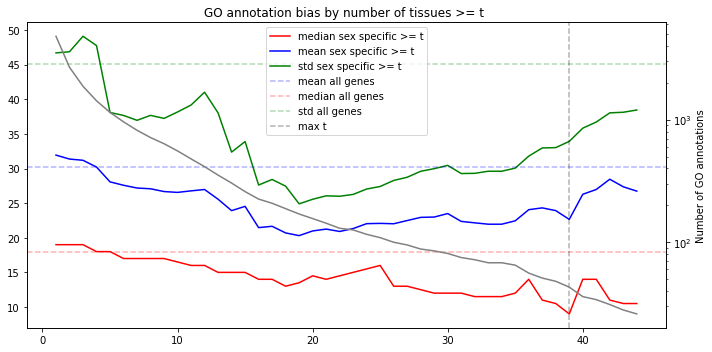

In [47]:
# same as above with with rolling t values, all genes >= t
# plot the median and mean number of annotations at each t
# get the median and mean number of annotations at each t
medians_at_t = []
means_at_t = []
stds_at_t = []
num_genes = []
for t in range(1,45):
    df_male_t = df_male[df_male['tissue_count'] >= t]
    df_female_t = df_female[df_female['tissue_count'] >= t]
    # get the median and mean number of annotations at t
    num_annotations_at_max_t = list(df_male_t['GO_annotations']) + list(df_female_t['GO_annotations'])
    medians_at_t.append(np.median(num_annotations_at_max_t))
    means_at_t.append(np.mean(num_annotations_at_max_t))
    stds_at_t.append(np.std(num_annotations_at_max_t))
    num_genes.append(len(num_annotations_at_max_t))

# plot the median and mean number of annotations at each t
fig, ax = plt.subplots()
# chagne fig size
fig.set_size_inches(10, 5)
ax.plot(range(1,45),medians_at_t, label='median sex specific >= t',color='red')
ax.plot(range(1,45),means_at_t, label='mean sex specific >= t',color='blue')
ax.plot(range(1,45),stds_at_t, label='std sex specific >= t',color='green')

# plot the mean, median and std of all_gene_go_counts as horizontal lines
plt.axhline(y=np.mean(all_gene_go_counts), color='blue', linestyle='--', label='mean all genes',alpha=.3)
plt.axhline(y=np.median(all_gene_go_counts), color='red', linestyle='--', label='median all genes',alpha=.3)
plt.axhline(y=np.std(all_gene_go_counts), color='green', linestyle='--', label='std all genes',alpha=.3)

# mark the max t with a verticle line that is alpha = .3
plt.axvline(x=max_t, color='black', linestyle='--', alpha=.3, label='max t')
plt.legend()
# plot a grey line for the number of genes being considered
ax2 = ax.twinx()
ax2.plot(range(1,45),num_genes, label='number of genes',color='grey')
ax2.set_ylabel('Number of genes')
# log scale ax2 y
ax2.set_yscale('log')

plt.xlabel('Number of tissues')
plt.ylabel('Number of GO annotations')
plt.title('GO annotation bias by number of tissues >= t ')

plt.tight_layout()
plt.savefig('../Figures/go_annotation_bias_by_tissue_median_mean_std_gr8r_than_t.png')

## HPO

In [49]:
# load the number of HPO annotations for each gene
hpo_annotations = {}
g2p = pd.read_csv('../Resources/genes_to_phenotype.Nov_29_2022.txt',sep='\t',comment='#',header=None)
g2p.columns = ['entrez-gene-id','entrez-gene-symbol','HPO-Term-ID','HPO-Term-Name','Frequency-Raw','Frequency-HPO','Additional Info from G-D source','G-D source','disease-ID for link']
print(g2p)
hpo_annotations = { g: sum(g2p['entrez-gene-symbol'] == g) for g in g2p['entrez-gene-symbol'].unique()}
print(hpo_annotations)

# add this information to each of the DFs
df_female['HPO_annotations'] = [hpo_annotations[g] if g in hpo_annotations else 0 for g in df_female['gene']]
df_male['HPO_annotations'] = [hpo_annotations[g] if g in hpo_annotations else 0 for g in df_male['gene']]

        entrez-gene-id entrez-gene-symbol HPO-Term-ID  \
0                 8192               CLPP  HP:0000252   
1                 8192               CLPP  HP:0000815   
2                 8192               CLPP  HP:0004322   
3                 8192               CLPP  HP:0001250   
4                 8192               CLPP  HP:0000013   
...                ...                ...         ...   
269989           57338               JPH3  HP:0000726   
269990           57338               JPH3  HP:0000741   
269991           57338               JPH3  HP:0000738   
269992           57338               JPH3  HP:0001347   
269993           57338               JPH3  HP:0002072   

                         HPO-Term-Name Frequency-Raw Frequency-HPO  \
0                         Microcephaly             -    HP:0040283   
1       Hypergonadotropic hypogonadism             -           NaN   
2                        Short stature             -    HP:0040283   
3                              Seiz

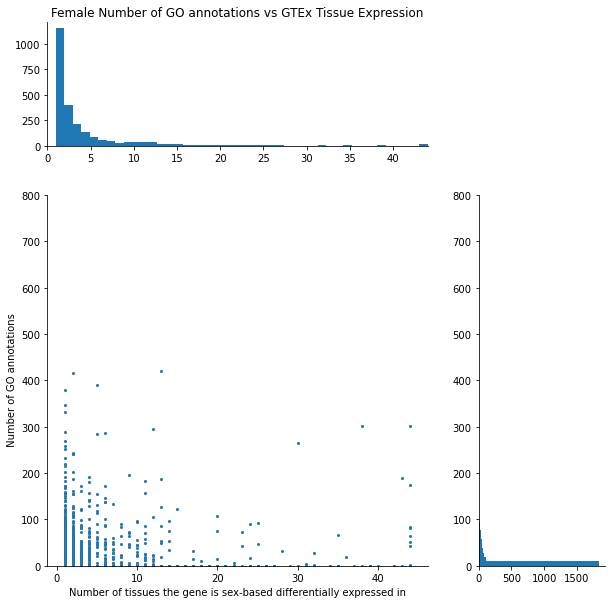

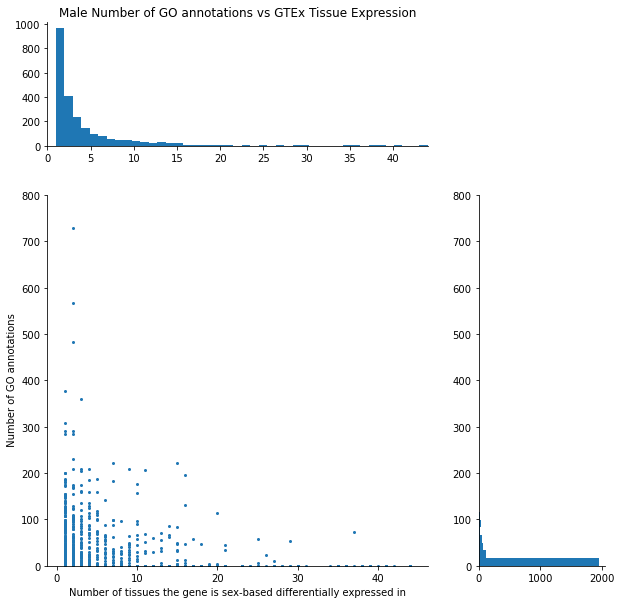

<Figure size 432x288 with 0 Axes>

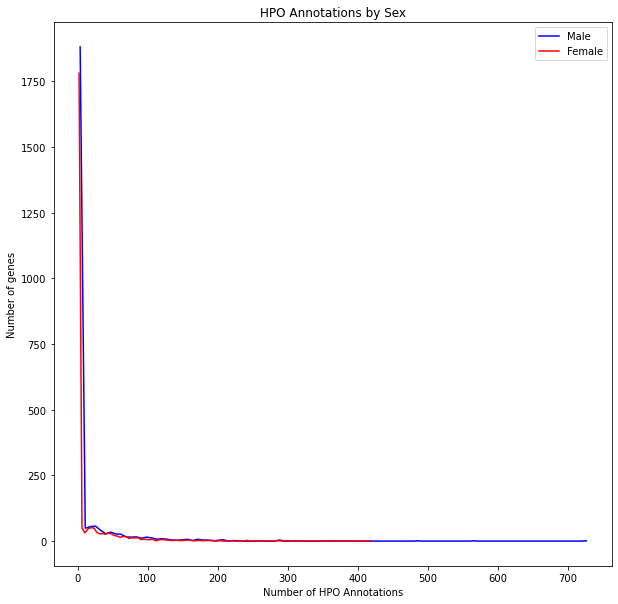

In [28]:
# plot the hpo annotations by sex like we did for the GO annotations

# x, y, output, xlab=None, ylab=None, ylim=None, title=None
gtex_scatter_with_densities(x=df_female['tissue_count'],
                            y=df_female['HPO_annotations'],
                            output='../Figures/female_hpo_v_gtex_scatter.png',
                            ylab=' Number of GO annotations',
                            ylim=(0,800),
                            title='Female Number of GO annotations vs GTEx Tissue Expression')

gtex_scatter_with_densities(x=df_male['tissue_count'],
                            y=df_male['HPO_annotations'],
                            output='../Figures/Male_hpo_v_gtex_scatter.png',
                            ylab=' Number of GO annotations',
                            ylim=(0,800),
                            title='Male Number of GO annotations vs GTEx Tissue Expression')

compare_annotations_by_sex(df_female['HPO_annotations'],
                            df_male['HPO_annotations'],
                            title='HPO Annotations by Sex',
                            output='../Figures/hpo_annotations_by_sex.png',
                            xlabel='Number of HPO Annotations')


In [48]:
"""
for t in T, number of tissues a gene is sex-specifically expressed in (1-44)
is the number of GO annotations at t different than expected by chance?
"""
all_gene_hpo_counts = [hpo_annotations[g] if g in hpo_annotations else 0 for g in all_gene_symbols]

ps_at_t = []
ts = []
for t in range(1,max([max(df_male['tissue_count']), max(df_female['tissue_count']) ])+1):
    print('for genes expressed in {} specific tissues'.format(t))
    # get the genes expressed in t tissues
    sub_female = df_female[df_female['tissue_count'] == t]
    sub_male = df_male[df_male['tissue_count'] == t]
    all_hpo_annos_at_t = list(sub_male['HPO_annotations']) + list(sub_female['HPO_annotations'])
    if len(all_go_annos_at_t) == 0:
        print('no genes expressed in {} tissues'.format(t))
        continue

    p_at_t = sample_and_ttest(all_hpo_annos_at_t, all_gene_hpo_counts, iterations=1000)
    ps_at_t.append(p_at_t)
    ts.append(t)
# plot the p-values at each t
plt.plot(ts,ps_at_t)
plt.xlabel('Number of tissues')
plt.ylabel('% test with p <0.05')
plt.title('HPO annotation bias by number of tissues')
plt.tight_layout()
plt.savefig('../Figures/HPO_annotation_bias_by_tissue.png')
plt.show()

for genes expressed in 1 specific tissues


KeyError: 'HPO_annotations'